# МОиВС "Генеративные модели", 5-й модуль

# Homework 1

В этой домашней работе вам предстоит добавить к BERT'у декодерную часть и решить задачу генерации суммаризаций для текстов новостей на русском языке.

Дополнительно к этому на отличную оценку потребуется реализовать подсчет метрик качества и менее жадную стратегию выбора следующего токена для генерации.

*Мы сразу вас предостерегаем попасть в петлю бесконечного дообучения модели. Эта домашка не на пробитие скора. Мы будем проверять, что вы, в целом, сделали все верно и смогли получить какую-то более-менее адекватную (такую, которая заметно лучше той, что была до начала обучения) генерацию. Таким образом, если вы видите, что модель учится, не надо дообучать её сутками. Нескольких часов точно должно хватить.*



---


---
По любым вопросам касательно этой домашней работы обращайтесь ко своим ассистентам




In [1]:
%%bash
pip install transformers datasets evaluate

In [2]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, AutoTokenizer

## Подготовка данных (0.5 балла)

Мы воспользуемся датасетом с 🤗 Ильи Гусева "gazeta". Он представляет собой пары (полный текст новости -- его саммари). Пары были взяты с одноименного сайта в домене .ru

Более подробно про датасет можно прочитать [здесь](https://huggingface.co/datasets/IlyaGusev/gazeta)



In [3]:
# Загрузим данные с попощью библиотеки библиотеки datasets

from datasets import load_dataset
dataset = load_dataset('IlyaGusev/gazeta', revision="v2.0", split='train[:5%]')


In [4]:
dataset

Dataset({
    features: ['text', 'summary', 'title', 'date', 'url'],
    num_rows: 3048
})

Вы должны помнить, что тексты перед подачей в модель необходимо **токенизировать**.

Добавьте паддинг до `max_length=512` для обучающих данных, а также до `max_length=128` для меток.

Используйте обрезку текстов, длина которых в токенах превышает `max_length`

In [5]:
# Подготовим данные для модели Bert

model_name = 'deepvk/bert-base-uncased' # Указание модели BERT

tokenizer = AutoTokenizer.from_pretrained(model_name)
# special_tokens = {'eos_token': '[EOS]'}
# tokenizer.add_special_tokens(special_tokens)

def preprocess(examples, use_padding=True):
    model_inputs = tokenizer(examples['text'], padding= 'max_length' if use_padding else '', truncation=True, max_length=512)
    summary = tokenizer(examples['summary'], padding= 'max_length' if use_padding else '', truncation=True, max_length=128)
    model_inputs['labels'] = summary['input_ids']
    return model_inputs

/Users/sprilut/miniconda3/envs/ml/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
tokenized_dataset = dataset.map(preprocess, batched=False)
tokenized_dataset.set_format('torch')

Размер батча советуем подбирать таким образом, чтоб утилизировать максимум доступной VRAM

In [7]:
tokenized_dataset

Dataset({
    features: ['text', 'summary', 'title', 'date', 'url', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 3048
})

In [8]:
from torch.utils.data import DataLoader
splitted_dataset = tokenized_dataset.train_test_split(test_size=0.2)
train_dataloader = DataLoader(splitted_dataset['train'], batch_size=8, shuffle=True)
eval_dataloader = DataLoader(splitted_dataset['test'], batch_size=8, shuffle=False)

In [9]:
train_dataloader

In [10]:
# a.size()[:2]

NameError: name 'a' is not defined

In [ ]:
a = torch.tensor([[1,0,0], [1,1,0], [1,1,1], [2,0,0], [2,2,0], [2,2,2]])
b = torch.cat([torch.full((a.size()[0], 1), 100), a[:,:-1]], dim=1)

# torch.full((3, 1, 1,), 100), a
# a
b.T, b.transpose(0,1)


(tensor([[100, 100, 100, 100, 100, 100],
         [  1,   1,   1,   2,   2,   2],
         [  0,   1,   1,   0,   2,   2]]),
 tensor([[100, 100, 100, 100, 100, 100],
         [  1,   1,   1,   2,   2,   2],
         [  0,   1,   1,   0,   2,   2]]))

## Реализация Decoder-cети (3 балла)

В данном разделе вам необходимо **реализовать собственный декодер для генерации текста**.

Можете вдохновляться кодом с семинара 1 по GPT. В инициализации весов стоит (но необязательно) проявить смекалку

In [ ]:
bert = BertModel.from_pretrained('deepvk/bert-base-uncased')

In [ ]:
torch.full([a.size()[0], 1], tokenizer.sep_token_id)

tensor([[2],
        [2]])

In [29]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

# Класс модели для суммаризации на основе BERT с кастомным декодером
nn.Transformer
class BertSummarizer(nn.Module):
    def __init__(self, tokenizer, bert_model_name='bert-base-uncased', hidden_size=768, num_decoder_layers=3, num_heads=8, dropout=0.1):
        super(BertSummarizer, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.hidden_size = hidden_size
        self.tokenizer = tokenizer
        # Эмбеддинги для токенов на входе в декодер
        self.embedding = nn.Embedding(self.bert.config.vocab_size, hidden_size)

        # Attention головы
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads, dropout=dropout, batch_first=True),
            num_layers=num_decoder_layers,
        )
        self.fc_out = nn.Linear(hidden_size, self.bert.config.vocab_size)
        self.softmax = nn.Softmax(dim=2)

    # Функция для создания маски для предотвращения заглядывания вперед в декодере
    def generate_square_subsequent_mask(self, T):
        return torch.triu(
            torch.full((T, T), float('-inf'), device=self.embedding.weight.device, dtype=torch.float64),
            diagonal=1,
        )

    def shift_decoder_input(self, input_ids):
        cls_column = torch.full([input_ids.size()[0], 1], self.tokenizer.sep_token_id)
        return torch.cat([cls_column, input_ids[:,:-1]], dim=1)

    def forward(self, input_ids, attention_mask, decoder_input_ids):
        encoder_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        memory = encoder_outputs.last_hidden_state  # Выходы BERT для использования в декодере
        # memory = memory.transpose(0, 1)
        return self.decoder_forward(decoder_input_ids, memory)

    def decoder_forward(self, input_ids, memory):
        shifted_ids = self.shift_decoder_input(input_ids)
        embedded = self.embedding(shifted_ids)
        decoder_attention_mask = self.generate_square_subsequent_mask(embedded.size(1)).to(input_ids.device)

        output = self.decoder.forward(tgt=embedded, memory=memory, tgt_mask=decoder_attention_mask)
        # return;
        output = self.fc_out(output.transpose(0,1))
        return output

    def generate(self, input_ids, attention_mask, tokenizer, max_len=50):
        encoder_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        memory = encoder_outputs.last_hidden_state
        batch_size = input_ids.size(0)

        # Начинаем с токена [CLS] или [BOS] (начало последовательности)
        decoder_input_ids = torch.full((batch_size, 1), tokenizer.cls_token_id, dtype=torch.long).to(input_ids.device)
        # print('decoder_input_ids', decoder_input_ids.size())
        
        memory = memory.transpose(0, 1)
        generated_tokens = []

        for _ in range(max_len):
            embedded = self.embedding(decoder_input_ids).transpose(0, 1)
            # print('embedded', embedded, embedded.size())
            # Генерация маски для предотвращения заглядывания вперед
            decoder_attention_mask = self.generate_square_subsequent_mask(embedded.size(0)).to(input_ids.device)
            # print('decoder_attention_mask', decoder_attention_mask, decoder_attention_mask.size())
            decoder_output = self.decoder(tgt=embedded, memory=memory, tgt_mask=decoder_attention_mask)
            # print('decoder_output', decoder_output.size())

            output = self.fc_out(decoder_output.transpose(0, 1))
            # print('output', output.size())
            # Получаем индекс токена с наибольшей вероятностью.
            # Помните, если EOS предсказан, прекращаем генерацию
            probs = self.softmax(output)
            # print('probs', probs.size())
            ids = torch.argmax(probs, dim=2)
            # print(probs[0, 0, ids])
            # print('ids', ids, ids.size())
            decoder_input_ids = torch.cat((decoder_input_ids, ids[:, -1:]), dim=1)
            # print('decoder_input_ids', decoder_input_ids, decoder_input_ids.size())
            # print((ids == tokenizer.eos_token_id).any())
            # print('decoder_input_ids.size()', decoder_input_ids.size())

            if (decoder_input_ids[0,-1] == tokenizer.sep_token_id):
                print('went after sep_token_id')
                break

        generated_sequence = tokenizer.decode(decoder_input_ids.squeeze().tolist(), skip_special_tokens=True)

        return generated_sequence

In [12]:
# Инициализируем нашу модель и посморим на ее архитектруру

model = BertSummarizer(bert_model_name=model_name, tokenizer=tokenizer)
# model = model.to('cuda')
# model
# eval_data_sample = next(iter(eval_dataloader))

# model.generate(eval_data_sample['input_ids'][:1], eval_data_sample['attention_mask'][:1], tokenizer)
# eval_data_sample['input_ids'].size()

## Обучение модели (1 балл)

<small> 0.25 балла за простейший рабочий цикл; </small>

<small> +0.5 балла за графики для лосса и метрик на трейне и валидации.</small>

В данном разделе вам необходимо **реализовать цикл для обучения модели**


In [26]:
len(train_dataloader)

305

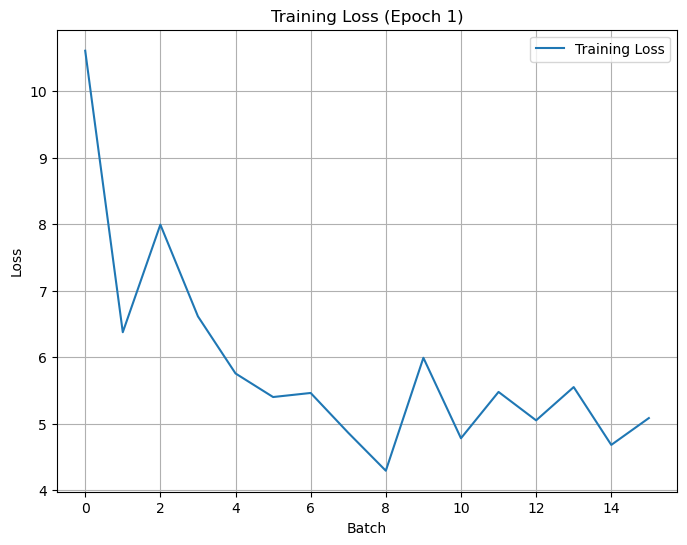

                                                        
Training Progress:   0%|          | 0/5 [03:23<?, ?it/s]       

Epoch [1/5], Loss: 5.0837


In [31]:
# Пример обучения на одной итерации
import torch.optim as optim
from tqdm import tqdm  # Для отображения прогресса
import matplotlib.pyplot as plt
from IPython.display import clear_output

model = BertSummarizer(bert_model_name=model_name, tokenizer=tokenizer)

def train_step(model, input_ids, attention_mask, decoder_input_ids, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    outputs = model(input_ids, attention_mask, decoder_input_ids)
    loss = criterion(outputs.view(-1, outputs.size(-1)), decoder_input_ids.view(-1))
    loss.backward()
    optimizer.step()

    return loss.item()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
train_data_sample = next(iter(train_dataloader))

# model.generate([:1], eval_data_sample['attention_mask'][:1], tokenizer)
losses = []
num_epochs = 5
plt.ion()  # Включаем интерактивный режим для обновления графика
for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    batch_iterator = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    running_loss = 0
    for batch_idx, sample in enumerate(batch_iterator):
        loss_item = train_step(model, sample['input_ids'], sample['attention_mask'], sample['labels'], optimizer, criterion)
        losses.append(loss_item)
        clear_output(wait=True)  # Очищаем старый график
        plt.figure(figsize=(8, 6))
        plt.plot(losses, label='Training Loss')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.title(f'Training Loss (Epoch {epoch+1})')
        plt.grid(True)
        plt.legend()
        plt.show()
        running_loss += loss_item
        tqdm.write(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_item:.4f}')
    epoch_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
plt.ioff()  # Отключаем интерактивный режим
plt.show()  # Показываем итоговый график


# train_data_sample['input_ids'].size()[0]
# train_data_sample['token_type_ids']
# plt.plot(loss_arr)

## Метрики качества (1 балл)

<small>По 0.33 балла за реализацию каждой из предлагаемых метрик</small>

**Реализуйте функицию для подсчета метрик качества суммаризации.**

Докуметация по некотрым метрикам:
 1. [HuggingFace Rouge](https://huggingface.co/spaces/evaluate-metric/rouge)
 2. [HuggingFace Bleu](https://huggingface.co/spaces/evaluate-metric/bleu)
 3. [HuggingFace BERT Score](https://huggingface.co/spaces/evaluate-metric/bertscore)

In [ ]:
def compute_metrics():
    #<YOUR CODE HERE>
    pass

def evaluation():
    #<YOUR CODE HERE>
    pass

## Обучение модели (0.5 балла)
**Обучите модель, сохраните лучшую версию** (метод `.save_pretrained()` объекта класса AutoModel... или `torch.save()`) **и добавьте пример генерации**. Учтите, что если изменялся токенизатор (а лучше просто по умолчанию), его тоже нужно сохранить. Если планируете продолжить обучение

Для сравнения оценки качества генерации по значениям реализованных метрик можете запустить ruT5-small без дообучения. Мы намеренно даем бейзлайн именно в таком виде.

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained("YOUR MODEL")
summary = #<YOUR CODE HERE>

## Реализация менее жадных стратегий выбора следующего токена (4 балла)
Всегда ли выбор наиболее вероятного токена на каждом шаге – это лучшая стратегия для генерации текста?

<details>
    <summary>Спойлер</summary>
    <p>Нет</p>
</details>

**Сравнение стратегий для генерации текста:**

| Strategy | Description | Pros & Cons |
| --- | --- | --- |
| Greedy Search | Chooses the word with the highest probability as the next word in the sequence. | **Pros:** Simple and fast. <br><br/> **Cons:** Can lead to repetitive and incoherent text. |
| Sampling with Temperature | Introduces randomness in the word selection. A higher temperature leads to more randomness. | **Pros:** Allows exploration and diverse output. <br><br/> **Cons:** Higher temperatures can lead to nonsensical outputs. |
| Nucleus Sampling (Top-p Sampling) | Selects the next word from a truncated vocabulary, the "nucleus" of words <br/> that have a cumulative probability exceeding a pre-specified threshold (p). | **Pros:** Balances diversity and quality. <br><br/> **Cons:** Setting an optimal 'p' can be tricky. |
| Beam Search | Explores multiple hypotheses (sequences of words) at each step, and keeps <br/> the 'k' most likely, where 'k' is the beam width. | **Pros:** Produces more reliable results than greedy search. <br><br/> **Cons:** Can lack diversity and lead to generic responses. |
| Top-k Sampling | Randomly selects the next word from the top 'k' words with the highest probabilities. | **Pros:** Introduces randomness, increasing output diversity. <br><br/> **Cons:** Random selection can sometimes lead to less coherent outputs. |
| Length Normalization | Prevents the model from favoring shorter sequences by dividing the log probabilities <br/> by the sequence length raised to some power. | **Pros:** Makes longer and potentially more informative sequences more likely. <br><br/> **Cons:** Tuning the normalization factor can be difficult. |
| Stochastic Beam Search | Introduces randomness into the selection process of the 'k' hypotheses in beam search. | **Pros:** Increases diversity in the generated text. <br><br/> **Cons:** The trade-off between diversity and quality can be tricky to manage. |
| Decoding with Minimum Bayes Risk (MBR) | Chooses the hypothesis (out of many) that minimizes expected loss under a loss function. | **Pros:** Optimizes the output according to a specific loss function. <br><br/> **Cons:** Computationally more complex and requires a good loss function. |

Ссылки на докуметацию:
- [reference for `AutoModelForCausalLM.generate()`](https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/text_generation#transformers.GenerationMixin.generate)
- [reference for `AutoTokenizer.decode()`](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.decode)
- Huggingface [docs on generation strategies](https://huggingface.co/docs/transformers/generation_strategies)

**1. Дополните метод `generate` в модели, чтобы получать топ-k самых вероятных токена и их "вероятности"** (1 балл).   

**2. Реализуйте стратегию Nucleus Sampling в методе `generate`** (1 балл)

**3. Реализуйте стратегию Beam Search** (2 балла)

Получилось ли улучшить генерацию?

## Послевкусие (0 баллов)

Если эта домашняя работа показалась вам недостаточно большой, предлагаем провести следующий эксперимент:

- от имеющейся модели "откусить" только декодерную часть (откусить также можно от ruT5-small);
- немного дообучить (что называется, по вкусу);
- посмотреть качество генерации по метрикам и "глазами";
- сравнить полученное с Encoder-Decoder архитектурой;
- ответить на вопрос "Дает ли применение Encoder-Decoder архитектуры значительный буст в качестве генерации, или это некоторый overkill?" (базово, ответ лежит на поверхности 😸)

Ещё более опционально можно:
- почитать про возможности генерации Encoder-only архитектурными решениями (BERT, e.g.)
- сравнить с генерацией только Decoder'ом и both Encoder-Decoder'ом;
- в т.ч. подобрать число обучаемых параметров таким образом, чтоб оно было примерно одинаковым для каждого инстанса моделей (их, инстансов, будет 3 -- только энкодер, только декодер и энкодер-декодер).

*Вообще ориентироваться следует на следующее утверждение: "Только энкодерные архитектуры (BERT, e.g.) хороши для понимания текста (получения эмеддингов), лишь декодерные (GPT, например) -- для генерации, энкодер-декодерные (скажем, T5) -- для обеих задач"*